In [ ]:
import numpy as np
import pandas as pd
from keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense,BatchNormalization, Flatten, MaxPool2D
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape
from tensorflow.keras.utils import Sequence
from keras.backend import epsilon
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
# The ImageDataGenerator class has been moved to tensorflow.keras.preprocessing.image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import os

In [ ]:
!file "/content/archive.zip"


/content/archive.zip: Zip archive data, at least v4.5 to extract, compression method=deflate


In [ ]:
import zipfile
import os

zip_path = "/content/archive.zip"
extract_path = "/content/deepfake-detection"

os.makedirs(extract_path, exist_ok=True)

try:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print(f"Extraction completed! Files are in: {extract_path}")
except zipfile.BadZipFile:
    print("Error: The ZIP file is corrupted or invalid.")
except Exception as e:
    print(f"An error occurred: {e}")


Extraction completed! Files are in: /content/deepfake-detection


In [ ]:
!pip install timm

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 204MB/s]
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 231MB/s]


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:01<00:00, 189MB/s]
Epoch 1/5: 100%|██████████| 128/128 [01:55<00:00,  1.11it/s]


Epoch 1/5, Loss: 0.6376, Acc: 0.6198, F1: 0.6611, AUC: 0.6769


Epoch 2/5: 100%|██████████| 128/128 [01:51<00:00,  1.15it/s]


Epoch 2/5, Loss: 0.4526, Acc: 0.7908, F1: 0.8030, AUC: 0.8690


Epoch 3/5: 100%|██████████| 128/128 [01:50<00:00,  1.16it/s]


Epoch 3/5, Loss: 0.2345, Acc: 0.9108, F1: 0.9156, AUC: 0.9661


Epoch 4/5: 100%|██████████| 128/128 [01:50<00:00,  1.16it/s]


Epoch 4/5, Loss: 0.1408, Acc: 0.9500, F1: 0.9528, AUC: 0.9878


Epoch 5/5: 100%|██████████| 128/128 [01:49<00:00,  1.16it/s]


Epoch 5/5, Loss: 0.0976, Acc: 0.9657, F1: 0.9678, AUC: 0.9936


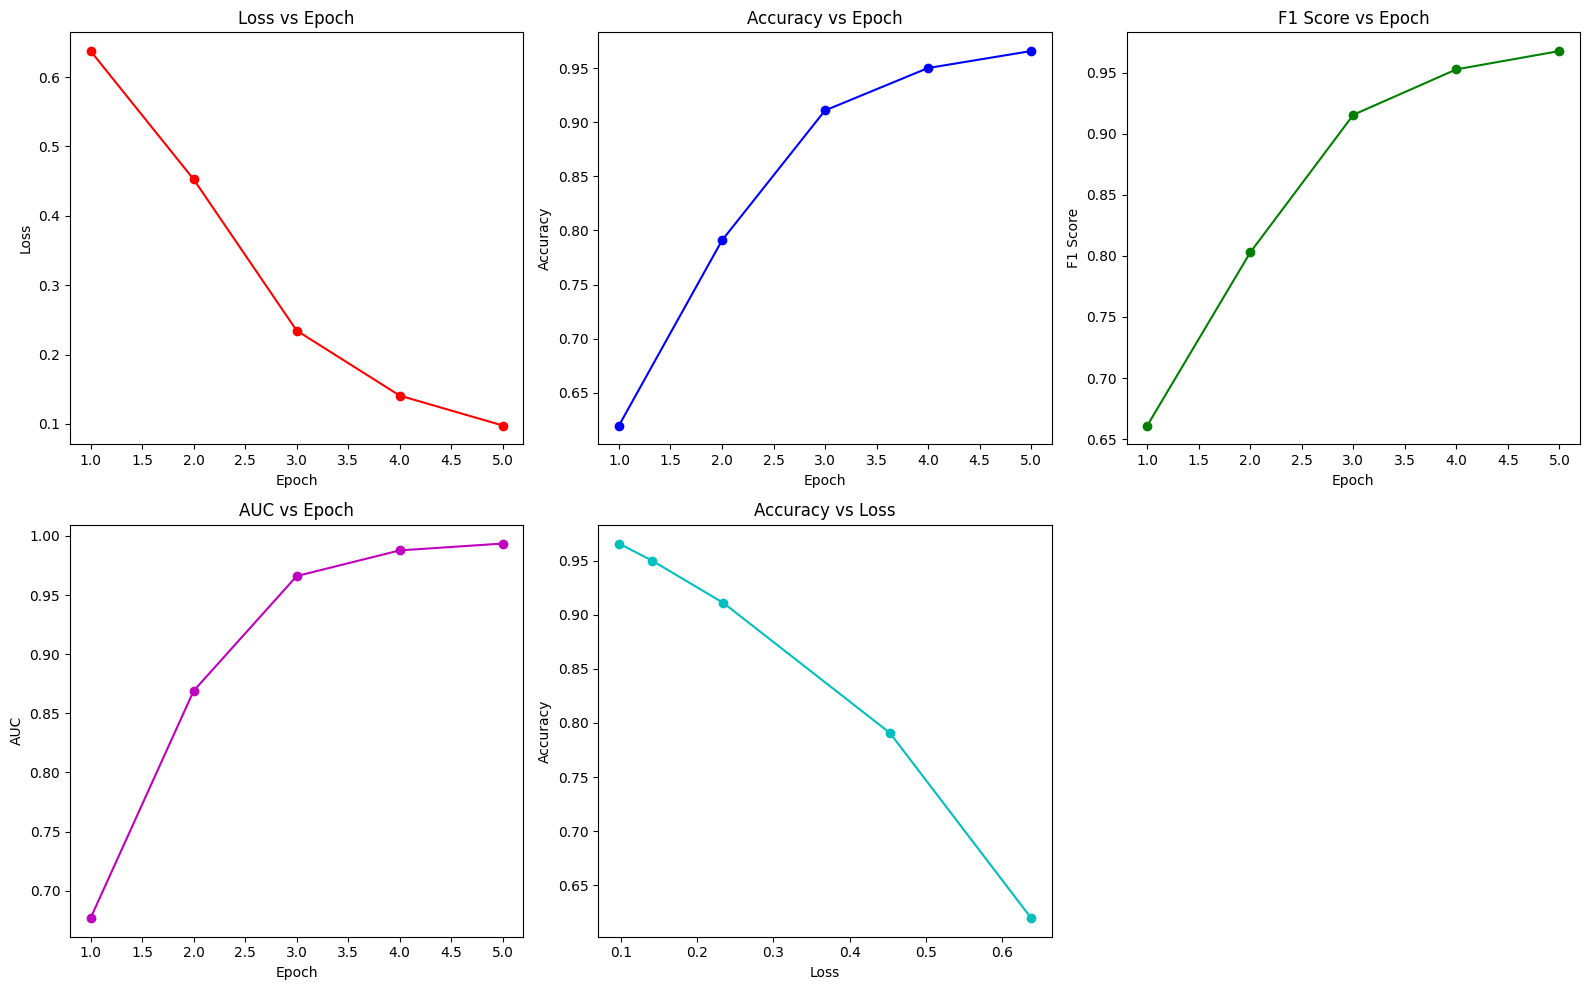

Accuracy: 0.9912
Precision: 0.9991
Recall: 0.9843
F1 Score: 0.9916
ROC AUC: 0.9999


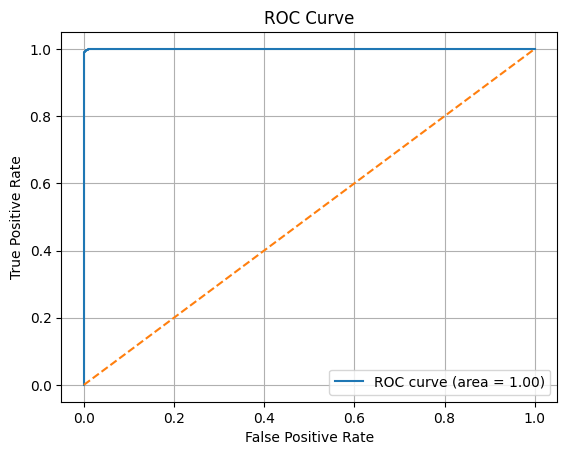

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models, datasets, transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------------------
# Ensemble Model: MobileNetV2 + EfficientNet-B0 + Vision Transformer (ViT_B_16)
# ------------------------------
class DeepfakeEnsemble(nn.Module):
    def __init__(self):
        super(DeepfakeEnsemble, self).__init__()

        # ---- MobileNetV2 ----
        self.mobilenet = models.mobilenet_v2(pretrained=True)
        self.mobilenet.classifier = nn.Identity()

        # ---- EfficientNet-B0 ----
        self.efficientnet = models.efficientnet_b0(pretrained=True)
        self.efficientnet.classifier = nn.Identity()

        # ---- Vision Transformer (ViT_B_16) ----
        # Using pretrained weights for better performance
        self.vit = models.vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT)
        self.vit.heads = nn.Identity()   # Remove classification head

        # ---- Combined Classifier ----
        self.dropout = nn.Dropout(0.4)
        # MobileNetV2 → 1280, EfficientNet-B0 → 1280, ViT-B_16 → 768
        self.classifier = nn.Sequential(
            nn.Linear(1280 + 1280 + 768, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x1 = self.mobilenet(x)
        x2 = self.efficientnet(x)
        x3 = self.vit(x)
        x_concat = torch.cat((x1, x2, x3), dim=1)
        return self.classifier(self.dropout(x_concat))
# ------------------------------
# Data Transform
# ------------------------------
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # For ViT, EfficientNet, and MobileNet
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
# Dataset & Loader
train_set = datasets.ImageFolder(root='./deepfake-detection', transform=data_transform)
train_loader = DataLoader(train_set, batch_size=16, shuffle=True)

# ------------------------------
# Initialize model, loss, optimizer
# ------------------------------
model = DeepfakeEnsemble().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# ------------------------------
# Checkpoint paths
# ------------------------------
checkpoint_path = "deepfake_ensemble_checkpoint.pth"
start_epoch = 0
num_epochs = 5

# Resume if checkpoint exists
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"Resuming from epoch {start_epoch}")

# ------------------------------
# Train function with metrics tracking
# ------------------------------
def train_model(model, loader, criterion, optimizer, start_epoch, num_epochs):
    history = {
        'epoch': [],
        'loss': [],
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'auc': []
    }

    for epoch in range(start_epoch, num_epochs):
        model.train()
        running_loss = 0.0
        y_true, y_pred, y_scores = [], [], []

        for inputs, labels in tqdm(loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = (outputs > 0.5).float()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_scores.extend(outputs.detach().cpu().numpy())

        # Compute metrics
        epoch_loss = running_loss / len(loader)
        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred)
        rec = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        auc = roc_auc_score(y_true, y_scores)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Acc: {acc:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")

        # Save metrics
        history['epoch'].append(epoch + 1)
        history['loss'].append(epoch_loss)
        history['accuracy'].append(acc)
        history['precision'].append(prec)
        history['recall'].append(rec)
        history['f1'].append(f1)
        history['auc'].append(auc)

        # Save checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
        }, checkpoint_path)

    return history

# ------------------------------
# Training and History Tracking
# ------------------------------
history = train_model(model, train_loader, criterion, optimizer, start_epoch, num_epochs)

# ------------------------------
# Plotting Training Metrics
# ------------------------------
def plot_training_history(history):
    epochs = history['epoch']

    plt.figure(figsize=(16, 10))

    plt.subplot(2, 3, 1)
    plt.plot(epochs, history['loss'], 'r-o')
    plt.title("Loss vs Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.subplot(2, 3, 2)
    plt.plot(epochs, history['accuracy'], 'b-o')
    plt.title("Accuracy vs Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")

    plt.subplot(2, 3, 3)
    plt.plot(epochs, history['f1'], 'g-o')
    plt.title("F1 Score vs Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")

    plt.subplot(2, 3, 4)
    plt.plot(epochs, history['auc'], 'm-o')
    plt.title("AUC vs Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("AUC")

    plt.subplot(2, 3, 5)
    plt.plot(history['loss'], history['accuracy'], 'c-o')
    plt.title("Accuracy vs Loss")
    plt.xlabel("Loss")
    plt.ylabel("Accuracy")

    plt.tight_layout()
    plt.show()

plot_training_history(history)

# ------------------------------
# Final Evaluation
# ------------------------------
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def evaluate_model(model, loader):
    model.eval()
    y_true, y_pred, y_scores = [], [], []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device).float()
            outputs = model(inputs).squeeze(1)
            preds = (outputs > 0.5).float()

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_scores.extend(outputs.cpu().numpy())

    # Compute metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_scores)

    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print(f"ROC AUC  : {auc:.4f}")

    # ------------------------------
    # Confusion Matrix
    # ------------------------------
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

    # ------------------------------
    # ROC Curve
    # ------------------------------
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()


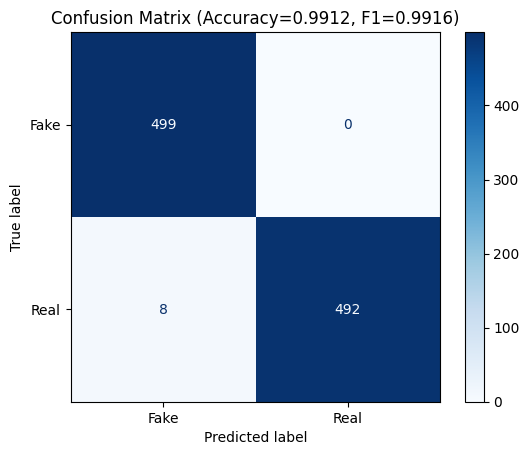

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np

cm = np.array([[499, 0],
               [8, 492]])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix (Accuracy=0.9912, F1=0.9916)")
plt.show()



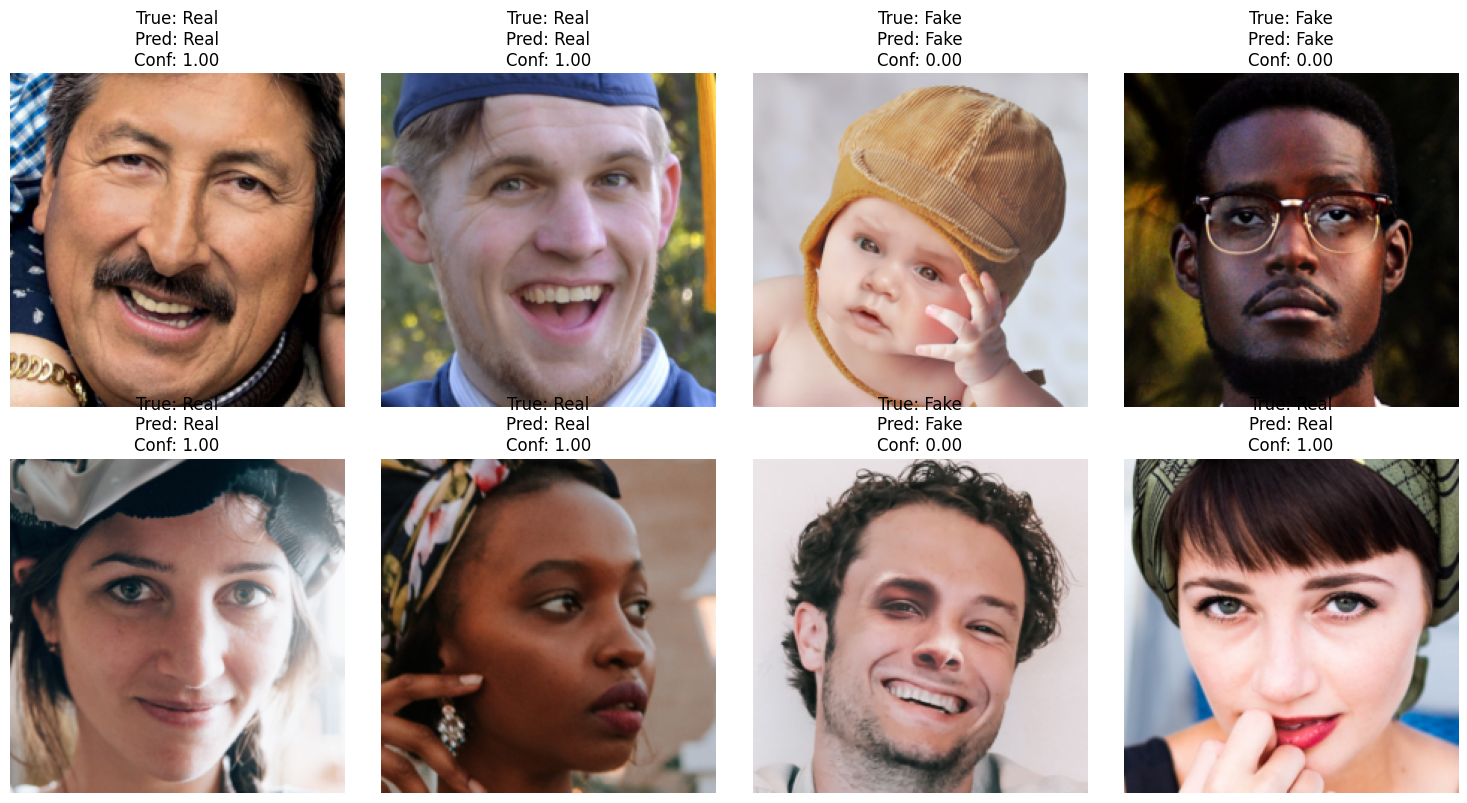


--- Performance on Random Test Samples ---
Accuracy : 1.0000
Precision: 1.0000
Recall   : 1.0000
F1 Score : 1.0000
ROC AUC  : 1.0000


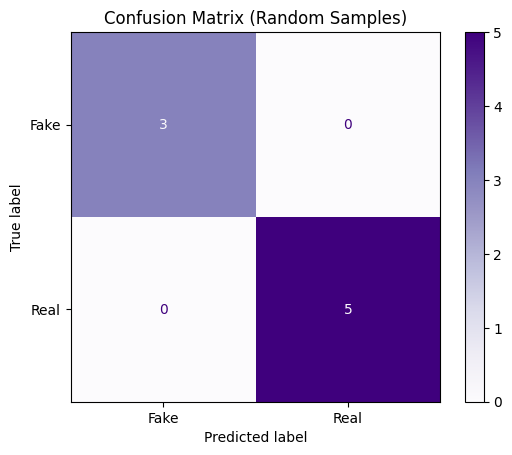

In [ ]:
import random
import numpy as np
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def test_random_images(model, dataset, num_images=8):
    model.eval()
    indices = random.sample(range(len(dataset)), num_images)

    y_true, y_pred, y_scores = [], [], []

    plt.figure(figsize=(15, 8))
    for i, idx in enumerate(indices):
        image, label = dataset[idx]
        input_tensor = image.unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(input_tensor).item()
            pred_label = 1 if output > 0.5 else 0
            y_true.append(label)
            y_pred.append(pred_label)
            y_scores.append(output)

        # Convert tensor to displayable image
        img = image.permute(1, 2, 0).cpu().numpy()
        img = np.clip(img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]), 0, 1)

        plt.subplot(2, (num_images + 1)//2, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"True: {'Real' if label==1 else 'Fake'}\nPred: {'Real' if pred_label==1 else 'Fake'}\nConf: {output:.2f}")

    plt.tight_layout()
    plt.show()

    # ------------------------------
    # Compute and Display Metrics
    # ------------------------------
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_scores)
    cm = confusion_matrix(y_true, y_pred)

    print(f"\n--- Performance on Random Test Samples ---")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print(f"ROC AUC  : {auc:.4f}")

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"])
    disp.plot(cmap=plt.cm.Purples)
    plt.title("Confusion Matrix (Random Samples)")
    plt.show()
test_random_images(model, train_set, num_images=8)

In [ ]:
!file "/content/test_samples.zip"


/content/test_samples.zip: Zip archive data, at least v2.0 to extract, compression method=store


In [ ]:
import zipfile
import os

zip_path = "/content/test_samples.zip"
extract_path = "/content/test_samples"

os.makedirs(extract_path, exist_ok=True)

try:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print(f"Extraction completed! Files are in: {extract_path}")
except zipfile.BadZipFile:
    print("Error: The ZIP file is corrupted or invalid.")
except Exception as e:
    print(f"An error occurred: {e}")


Extraction completed! Files are in: /content/test_samples


In [ ]:
import glob
from PIL import Image
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# --------------------------------------------
# Test function for external random images folder
# --------------------------------------------
def test_model_on_folder(model, folder_path):
    model.eval()
    y_true, y_pred, y_scores = [], [], []
    image_paths, class_names = [], []

    # Define transform (same as training)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    # Assuming folder structure:
    # random_test_images/
    # ├── Fake/
    # └── Real/
    #
    # This mirrors the structure used by ImageFolder.
    class_folders = sorted(os.listdir(folder_path))
    print(f"Detected classes: {class_folders}")

    for class_idx, cls in enumerate(class_folders):
        class_path = os.path.join(folder_path, cls)
        for img_path in glob.glob(os.path.join(class_path, "*")):
            try:
                image = Image.open(img_path).convert("RGB")
                image_tensor = transform(image).unsqueeze(0).to(device)

                with torch.no_grad():
                    output = model(image_tensor).item()
                    pred_label = 1 if output > 0.5 else 0

                y_true.append(class_idx)  # 0 = Fake, 1 = Real
                y_pred.append(pred_label)
                y_scores.append(output)
                image_paths.append(img_path)
                class_names.append(cls)

            except Exception as e:
                print(f"Skipping {img_path}: {e}")

    # ------------------------------
    # Compute metrics
    # ------------------------------
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_scores)
    cm = confusion_matrix(y_true, y_pred)

    print("\n--- Performance on Random Test Folder ---")
    print(f"Images Tested: {len(y_true)}")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print(f"ROC AUC  : {auc:.4f}")

    # ------------------------------
    # Plot Confusion Matrix
    # ------------------------------
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix (Random Image Folder)")
    plt.show()

    # ------------------------------
    # Show few predictions
    # ------------------------------
    sample_indices = np.random.choice(len(y_true), min(8, len(y_true)), replace=False)
    plt.figure(figsize=(14, 7))
    for i, idx in enumerate(sample_indices):
        img = Image.open(image_paths[idx]).convert("RGB")
        plt.subplot(2, 4, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"True: {class_names[idx]}\nPred: {'Real' if y_pred[idx]==1 else 'Fake'}\nConf: {y_scores[idx]:.2f}")
    plt.tight_layout()
    plt.show()


Detected classes: ['Fake', 'Real']

--- Performance on Random Test Folder ---
Images Tested: 3
Accuracy : 1.0000
Precision: 1.0000
Recall   : 1.0000
F1 Score : 1.0000
ROC AUC  : 1.0000


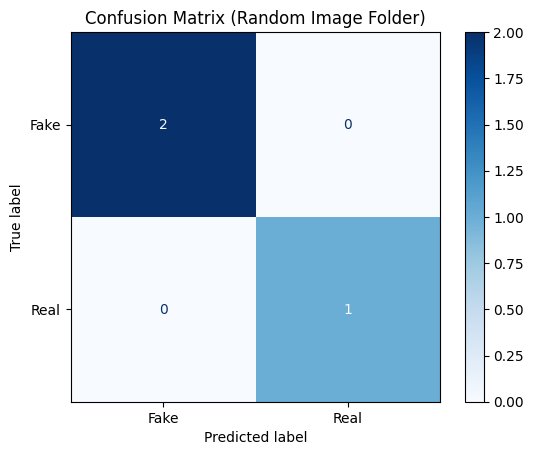

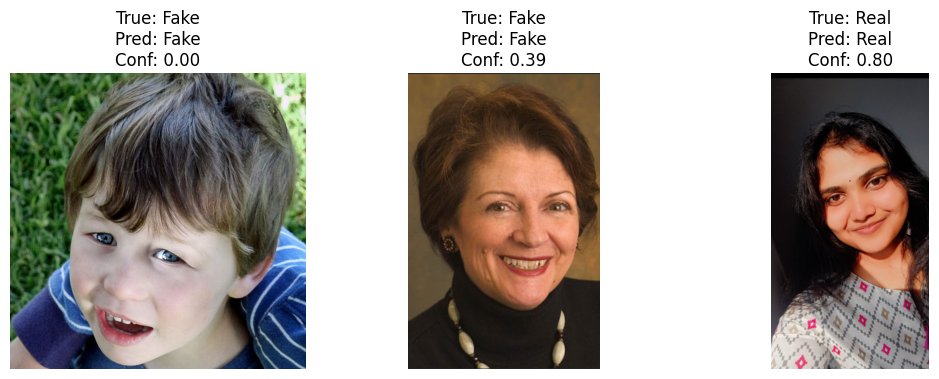

In [ ]:
test_model_on_folder(model, "./test_samples/test_samples")



In [1]:
import sys
sys.executable


'g:\\deepfake_repo\\deepfake_detection\\.venv\\Scripts\\python.exe'

In [2]:
pip install nbformat


Note: you may need to restart the kernel to use updated packages.


In [4]:
import nbformat

nb_path = "Deepfake_detection_improved_model.ipynb"
nb = nbformat.read(nb_path, as_version=4)

# Remove all widget metadata
for cell in nb.cells:
    if "metadata" in cell and "widgets" in cell["metadata"]:
        cell["metadata"].pop("widgets")

nbformat.write(nb, nb_path)
print("Widget metadata removed!")


Widget metadata removed!
